# Laboratory task 1
## Team of Vysotskiy Roman, Kozlyak Ruslan, Vershinin Vladislav

### Assignment

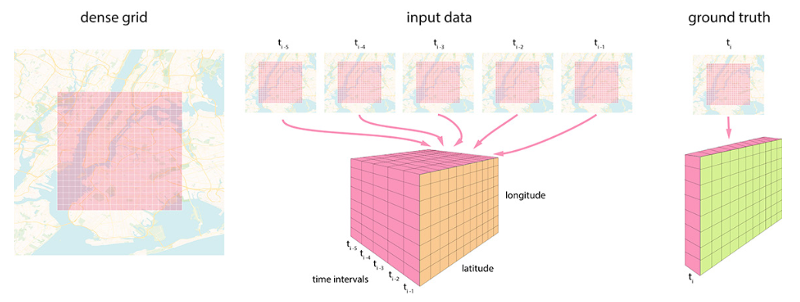

You are presented with a dataset of one popular social network that includes more than 8.5 million records with meta-information of publications over 13 months (January 2019 to February 2020).
Each publication is described by the following meta-information:
-	lon, lat – geoposition coordinates rounded up to a 250x250 meter polygon (geographical longitude and latitude, respectively)
-	timestamp – timestamp of the publication accurate to one hour
-	likescount – number of "likes" in the publication
-	commentscount – number of comments of the publication
-	symbols_cnt – number of all symbols in the publication
-	words_cnt – number of words (meaningful, not counting special characters and other meta-information)
-	hashtags_cnt – number of hashtags 
-	mentions_cnt – the number of mentions of other users
-	links_cnt – number of links
-	emoji_cnt – number of emoji
-	point – service field for matching coordinates from training, validation and test datasets (if two elements have the same point, they have the same coordinates, comparison of lat and lon may give an error)

Using this data, you will need to predict the number of publications in each 250x250 meter polygon for each hour 4 weeks (28 days) ahead of the last publication in the training set.
The square with coordinates of two opposite corners (60.039332, 30.515771) and (59.831191, 30.142969) can be considered as boundaries, it is guaranteed that in the test dataset the coordinates do not exceed these boundaries.


Notes
-	The length of the data set allows considering both the seasonal factor of activity changes and the general trend of growth/decline in the number of publications.
-	It is worth paying attention to the fact that the time parameters of publications can have a strong influence on the activity.
-	The density of the number of publications may vary greatly from district to district.


Validation dataset description
The validation dataset contains 710 cubes (250x250 meter polygon * 1 hour time interval) selected
at random from February 2020. Information about each cube includes:
- cube coordinates;
- hour;
- auxiliary field point – a string representation of the coordinate;
- sum – number of publications in the cube;
- error – baseline error value for the given cube.

The formula for an error calculation: 

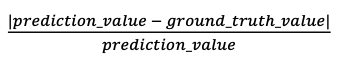

The average error of your model across all validation cubes should not exceed 2.6

# Import libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error, davies_bouldin_score

import lightgbm as lgb
from catboost import CatBoostRegressor

# Data preparation

In [2]:
train = pd.read_csv('train_data.csv')
train.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8526526 entries, 0 to 8526525
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   lon            float64
 2   lat            float64
 3   likescount     int64  
 4   commentscount  int64  
 5   symbols_cnt    int64  
 6   words_cnt      int64  
 7   hashtags_cnt   int64  
 8   mentions_cnt   int64  
 9   links_cnt      int64  
 10  emoji_cnt      int64  
 11  point          object 
dtypes: float64(2), int64(9), object(1)
memory usage: 780.6+ MB


In [4]:
train.shape

(8526526, 12)

Take a look on min and max value of timestamp

In [5]:
print(min(train['timestamp']), max(train['timestamp']))

1546300800 1580511600


In [3]:
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train['timestamp'].head()

0   2019-08-12 11:00:00
1   2019-08-12 00:00:00
2   2019-08-12 00:00:00
3   2019-08-12 00:00:00
4   2019-08-12 00:00:00
Name: timestamp, dtype: datetime64[ns]

In [4]:
train['hour'] = train['timestamp'].dt.hour 
train['day'] = train['timestamp'].dt.day
train['day_of_week'] = train['timestamp'].dt.weekday  
train['month'] = train['timestamp'].dt.month 

Lets look at the number of unique publicition places

In [8]:
len(train['point'].unique())

7041

It's quite big to make forecasting model for each polygon, so we have to make universal one

## Group values by feature point

In [ ]:
train_grouped = train.groupby(['point', 'timestamp', 'month', 'day', 'hour','day_of_week']).agg(sum=('point', 'count')).reset_index()
train_grouped.head()

,point,timestamp,month,day,hour,day_of_week,sum
0,0101000020E61000000000000000000000000000000000...,2019-01-01 00:00:00,1,1,0,1,3
1,0101000020E61000000000000000000000000000000000...,2019-01-01 01:00:00,1,1,1,1,2
2,0101000020E61000000000000000000000000000000000...,2019-01-01 02:00:00,1,1,2,1,2
3,0101000020E61000000000000000000000000000000000...,2019-01-01 05:00:00,1,1,5,1,3
4,0101000020E61000000000000000000000000000000000...,2019-01-01 06:00:00,1,1,6,1,2


Now we merge grouped data with raw dataset to get lat and lon for points

In [6]:
uniq_geo = train[['point', 'lon', 'lat']].drop_duplicates()

train_merged = train_grouped.merge(uniq_geo, on='point', how='left')

## Little feature engineering

Cyclic attributes, specifically sine and cosine functions, facilitate models in accurately discerning the periodicity inherent within datasets:

- Temporal cycles exhibit a repetitive nature (such as day/night, weekdays/weekends, and monthly cycles). 
- The incorporation of sine and cosine functions enables the consideration of the proximity between extreme values (for instance, hour 23 and hour 0). 

Scholarly investigations within the domains of time series analysis and neural networks indicate that such transformations significantly enhance the predictive accuracy for temporal data. This enhancement is particularly beneficial for linear models and decision trees, which lack the capability to independently recognize cyclic patterns.



In [7]:
train_merged['hour_sin'] = np.sin(train_merged['hour'] / 24 * 2 * np.pi)
train_merged['hour_cos'] = np.cos(train_merged['hour'] / 24 * 2 * np.pi)

train_merged['day_sin'] = np.sin(train_merged['day'] / 31 * 2 * np.pi)
train_merged['day_cos'] = np.cos(train_merged['day'] / 31 * 2 * np.pi)

train_merged['weekday_sin'] = np.sin(train_merged['day_of_week'] / 7 * 2 * np.pi)
train_merged['weekday_cos'] = np.cos(train_merged['day_of_week'] / 7 * 2 * np.pi)

train_merged['month_sin'] = np.sin(train_merged['month'] / 12 * 2 * np.pi)
train_merged['month_cos'] = np.cos(train_merged['month'] / 12 * 2 * np.pi)

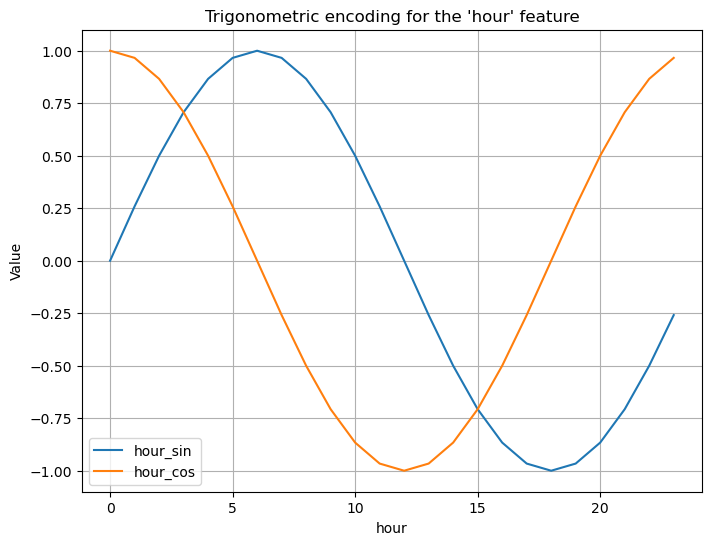

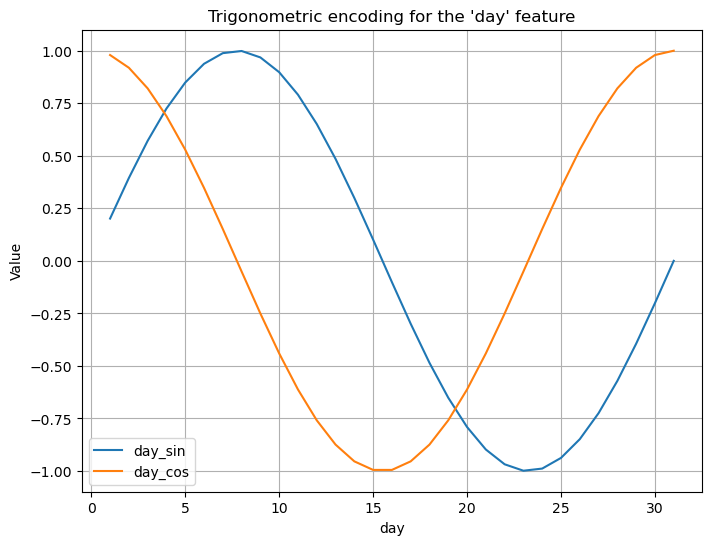

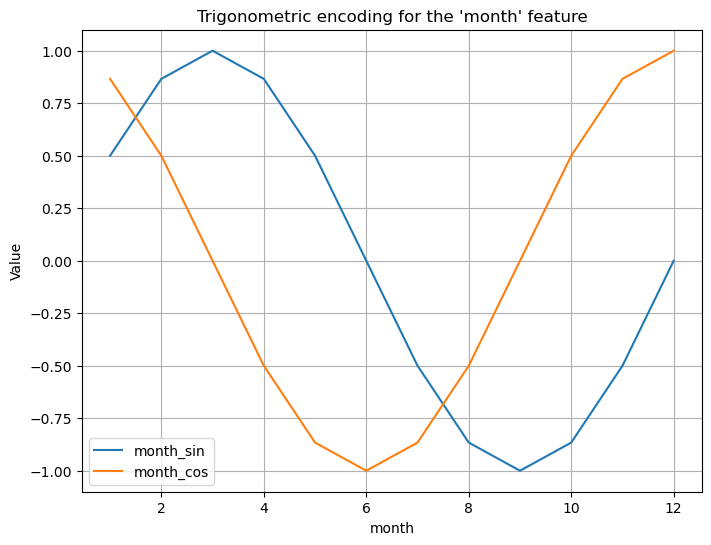

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

hours = np.arange(0, 24)
hour_sin = np.sin(hours / 24 * 2 * np.pi)
hour_cos = np.cos(hours / 24 * 2 * np.pi)

days = np.arange(1, 32)
day_sin = np.sin(days / 31 * 2 * np.pi)
day_cos = np.cos(days / 31 * 2 * np.pi)

months = np.arange(1, 13)
month_sin = np.sin(months / 12 * 2 * np.pi)
month_cos = np.cos(months / 12 * 2 * np.pi)

def plot_encoding(x, sin_values, cos_values, title, xlabel):
    plt.figure(figsize=(8, 6))
    plt.plot(x, sin_values, label=f'{xlabel}_sin')
    plt.plot(x, cos_values, label=f'{xlabel}_cos')
    plt.title(f"Trigonometric encoding for the '{xlabel}' feature")
    plt.xlabel(xlabel)
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_encoding(hours, hour_sin, hour_cos, "Hour Encoding", "hour")
plot_encoding(days, day_sin, day_cos, "Day Encoding", "day")
plot_encoding(months, month_sin, month_cos, "Month Encoding", "month")

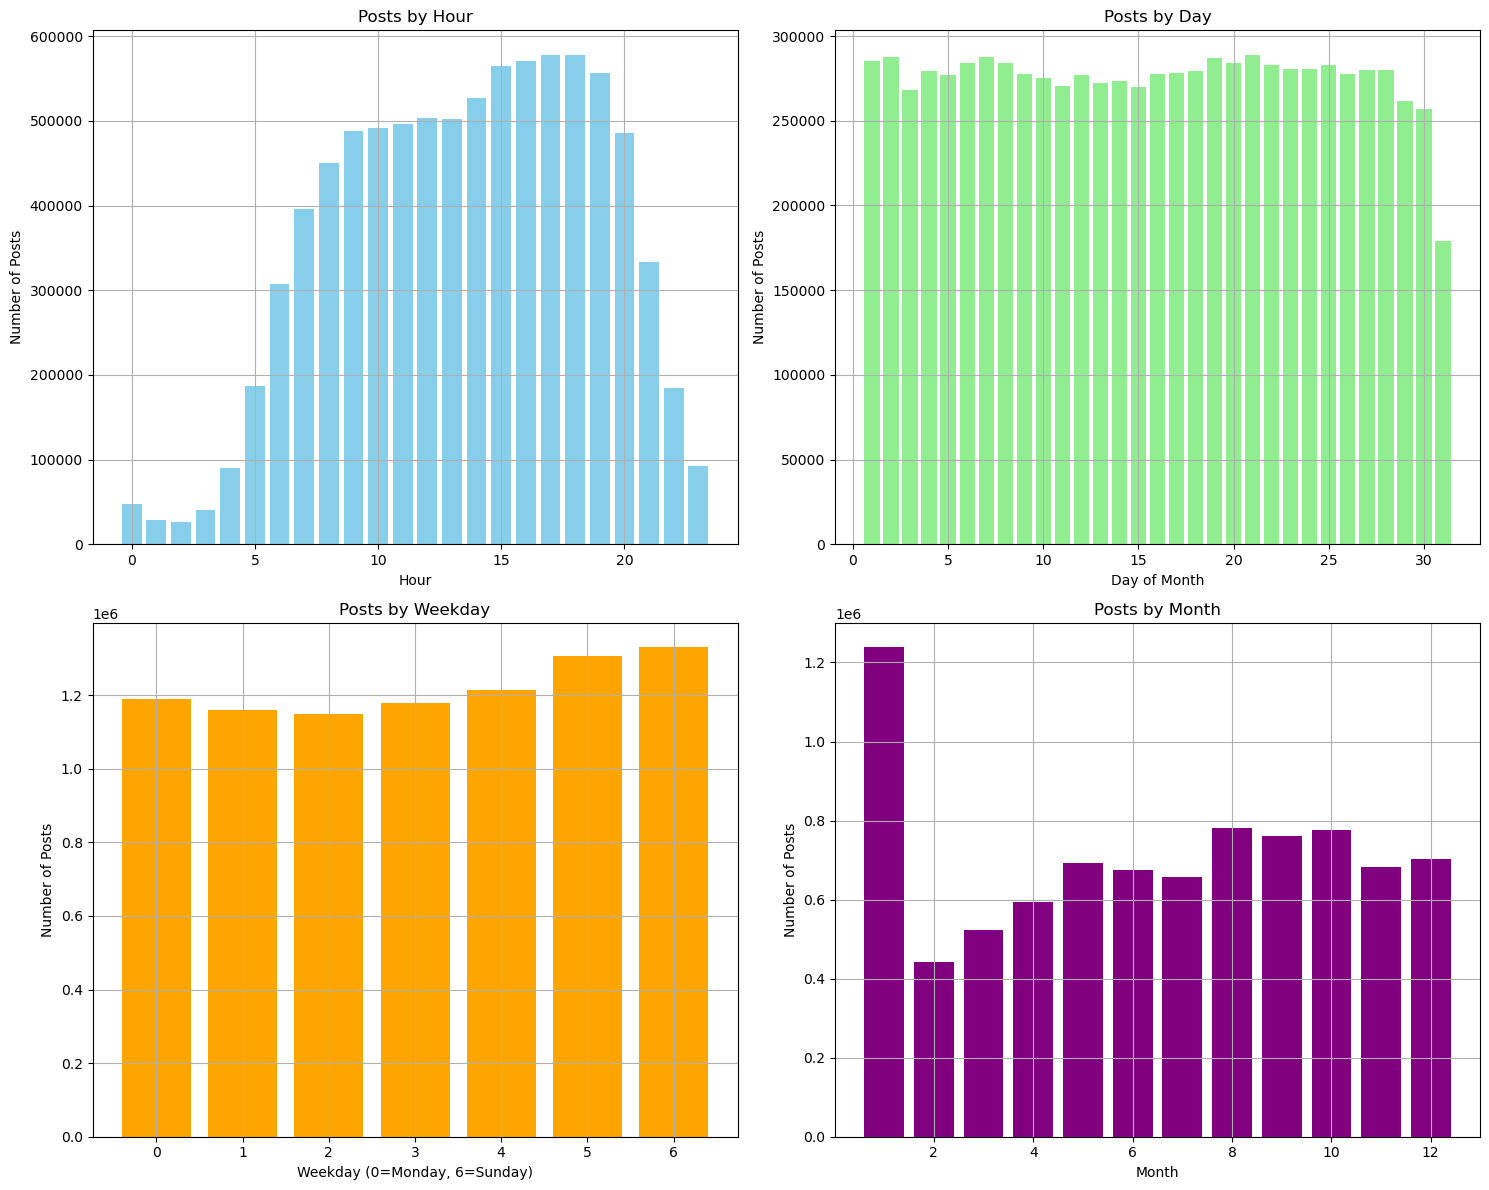

In [350]:
posts_by_hour = train_merged.groupby(train_merged['timestamp'].dt.hour)['sum'].sum()
posts_by_day = train_merged.groupby(train_merged['timestamp'].dt.day)['sum'].sum()
posts_by_weekday = train_merged.groupby(train_merged['timestamp'].dt.weekday)['sum'].sum()
posts_by_month = train_merged.groupby(train_merged['timestamp'].dt.month)['sum'].sum()

plt.figure(figsize=(15, 12))

# dist by hours
plt.subplot(2, 2, 1)
plt.bar(posts_by_hour.index, posts_by_hour.values, color='skyblue')
plt.title('Posts by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Posts')
plt.grid()

# dist by days
plt.subplot(2, 2, 2)
plt.bar(posts_by_day.index, posts_by_day.values, color='lightgreen')
plt.title('Posts by Day')
plt.xlabel('Day of Month')
plt.ylabel('Number of Posts')
plt.grid()

# dist by day of week
plt.subplot(2, 2, 3)
plt.bar(posts_by_weekday.index, posts_by_weekday.values, color='orange')
plt.title('Posts by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Number of Posts')
plt.grid()

# dist by month
plt.subplot(2, 2, 4)
plt.bar(posts_by_month.index, posts_by_month.values, color='purple')
plt.title('Posts by Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid()

plt.tight_layout()
plt.show()

As we can see in the 1 figure, number of posts increase sequently after 3 a.m. and go down after 7 p.m. (19:00), it's logial and it looks like truth. Also people often make posts on the weekends (Saturday and Sunday), on Friday it's slightly more than average across work days. 

So lets add some statistics for each point and then make clusterization

In [8]:
train_mean = train_merged.groupby(['point']).agg(
    mean=('sum', 'mean'),
    std=('sum', 'std'),
    mean_hour_sin=('hour_sin', 'mean'),
    mean_hour_cos=('hour_cos', 'mean'),
    mean_weekday_sin=('weekday_sin', 'mean'),
    mean_weekday_cos=('weekday_cos', 'mean'),
    mean_month_sin=('month_sin', 'mean'),
    mean_month_cos=('month_cos', 'mean'),
    ).reset_index()

train_mean['std'].fillna(0, inplace=True)

train_merged = train_merged.merge(train_mean, on='point', how='left')
train_merged.drop(columns=['month', 'day', 'hour', 'day_of_week'], inplace=True)

train_merged.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/1895573460.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_mean['std'].fillna(0, inplace=True)


,point,timestamp,sum,lon,lat,hour_sin,hour_cos,day_sin,day_cos,weekday_sin,...,month_sin,month_cos,mean,std,mean_hour_sin,mean_hour_cos,mean_weekday_sin,mean_weekday_cos,mean_month_sin,mean_month_cos
0,0101000020E61000000000000000000000000000000000...,2019-01-01 00:00:00,3,0.0,0.0,0.000000,1.000000e+00,0.201299,0.97953,0.781831,...,0.5,0.866025,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686
1,0101000020E61000000000000000000000000000000000...,2019-01-01 01:00:00,2,0.0,0.0,0.258819,9.659258e-01,0.201299,0.97953,0.781831,...,0.5,0.866025,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686
2,0101000020E61000000000000000000000000000000000...,2019-01-01 02:00:00,2,0.0,0.0,0.500000,8.660254e-01,0.201299,0.97953,0.781831,...,0.5,0.866025,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686
3,0101000020E61000000000000000000000000000000000...,2019-01-01 05:00:00,3,0.0,0.0,0.965926,2.588190e-01,0.201299,0.97953,0.781831,...,0.5,0.866025,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686
4,0101000020E61000000000000000000000000000000000...,2019-01-01 06:00:00,2,0.0,0.0,1.000000,6.123234e-17,0.201299,0.97953,0.781831,...,0.5,0.866025,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686


In [9]:
train_merged.shape

(3635541, 21)

In [10]:
train_mean.columns

Index(['point', 'mean', 'std', 'mean_hour_sin', 'mean_hour_cos',
       'mean_weekday_sin', 'mean_weekday_cos', 'mean_month_sin',
       'mean_month_cos'],
      dtype='object')

We began with 8.5 mln of rows and came to 3.6 mln, anyway it's a big amount of data to train. It might be a good idea to apply clusterization

## Clustering

In [ ]:
train_mean.set_index('point', drop=True, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_mean)

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


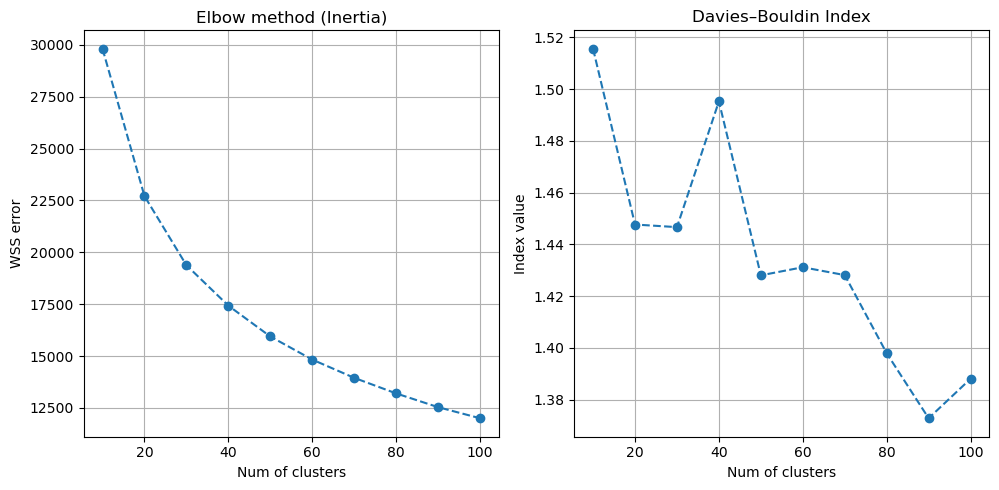

In [446]:
inertia = []
davies_bouldin_scores = []

cluster_range = range(10, 101, 10)

for n_clusters in tqdm(cluster_range):
    kmeans = KMeans(n_clusters=n_clusters, random_state=23, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
        
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow method (Inertia)')
plt.xlabel('Num of clusters')
plt.ylabel('WSS error')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='--')
plt.title('Davies–Bouldin Index')
plt.xlabel('Num of clusters')
plt.ylabel('Index value')

plt.tight_layout()
plt.grid()
plt.show()

In [15]:
kmeans = KMeans(n_clusters=50, random_state=23, n_init=10)
train_mean['kmeans'] = kmeans.fit_predict(X_scaled)

In [ ]:
train_mean['point'] = train_mean.index
train_mean.groupby('kmeans')['point'].count()

kmeans
0      96
1     668
2     226
3       4
4      10
5      55
6     285
7     361
8     484
9      91
10     87
11    174
12     49
13     38
14     35
15     58
16    738
17    166
18     49
19     37
20     89
21     62
22     27
23    187
24     27
25     83
26     34
27    264
28     31
29    313
30     18
31     15
32     30
33     34
34    155
35     13
36     39
37     48
38    633
39     27
40     30
41    399
42     41
43     25
44    148
45    212
46     53
47    253
48     21
49     19
Name: point, dtype: int64

## Visualize posts distribution

In [16]:
train_merged.sort_values(by='timestamp', ascending=True, inplace=True)

In [17]:
point = train_merged['point'].sample(1, random_state=23).values[0]

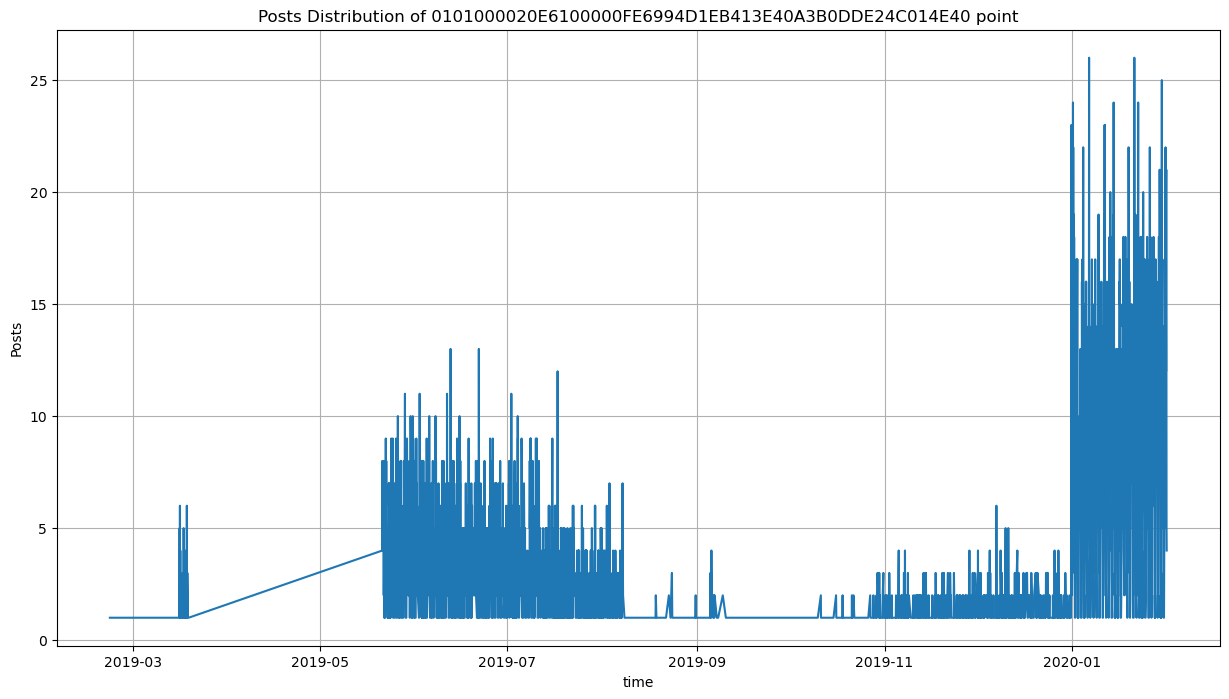

In [18]:
plt.figure(figsize=(15,8))

plt.plot(train_merged['timestamp'][train_merged['point'] == point], train_merged['sum'][train_merged['point'] == point])

plt.ylabel('Posts')
plt.xlabel('time')
plt.title(f'Posts Distribution of {point} point')
plt.grid()

## Correlation matrix

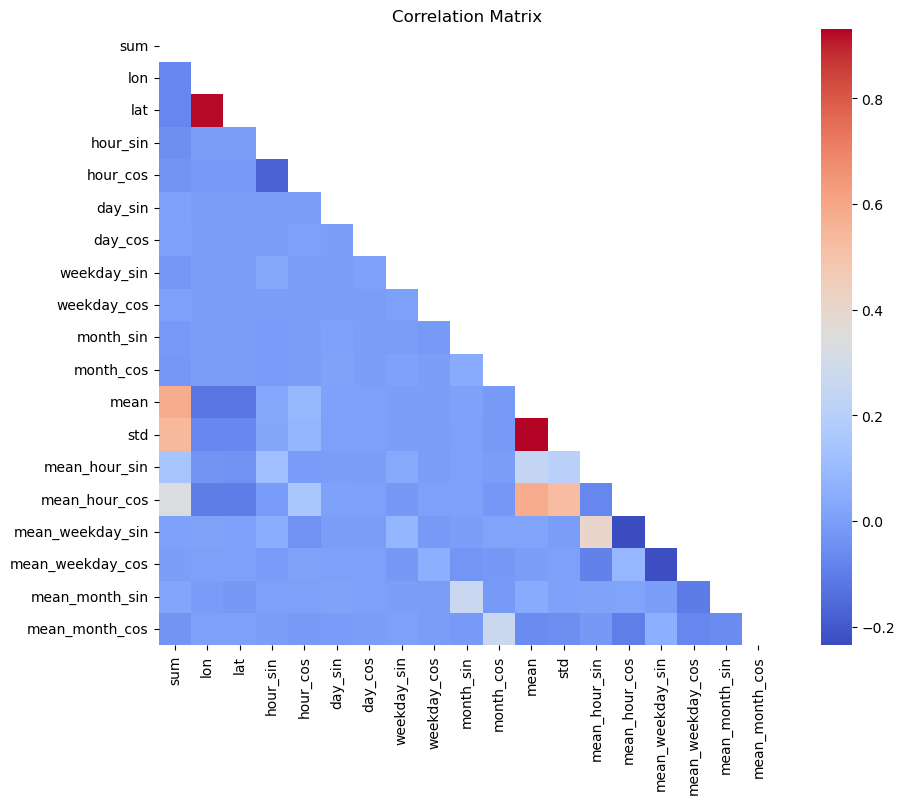

In [455]:
numeric_columns = train_merged.select_dtypes(include=['float64', 'int64', 'int32']).columns

correlation_matrix = train_merged[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)) ,
             annot=False, cmap='coolwarm', fmt='.2f', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

We see that atribbutes have small correlation between each other, we need to make something for good connections across them

## Polynomial transformation

In [19]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_poly = poly.fit_transform(train_merged.drop(columns=['timestamp', 'point', 'sum']))

train_prepared = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(input_features=train_merged.drop(columns=['timestamp', 'point', 'sum']).columns))

train_prepared.head()

,lon,lat,hour_sin,hour_cos,day_sin,day_cos,weekday_sin,weekday_cos,month_sin,month_cos,...,mean_hour_cos mean_weekday_sin,mean_hour_cos mean_weekday_cos,mean_hour_cos mean_month_sin,mean_hour_cos mean_month_cos,mean_weekday_sin mean_weekday_cos,mean_weekday_sin mean_month_sin,mean_weekday_sin mean_month_cos,mean_weekday_cos mean_month_sin,mean_weekday_cos mean_month_cos,mean_month_sin mean_month_cos
0,0.000000,0.000000,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,0.000428,0.000696,-0.003772,-0.005945,0.000030,-0.000163,-0.000257,-0.000265,-0.000417,0.002261
1,30.183394,59.849244,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,0.002431,-0.000376,-0.050865,-0.005037,-0.000010,-0.001399,-0.000139,0.000216,0.000021,0.002899
2,30.284454,59.919107,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,0.011568,0.016901,-0.006945,-0.057862,0.001965,-0.000808,-0.006729,-0.001180,-0.009830,0.004039
3,30.315895,59.965226,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,0.042497,0.006294,0.020068,-0.035986,0.001936,0.006174,-0.011071,0.000914,-0.001640,-0.005228
4,30.378777,60.033724,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,-0.002576,0.002437,-0.036610,-0.030139,-0.000084,0.001261,0.001038,-0.001193,-0.000982,0.014752


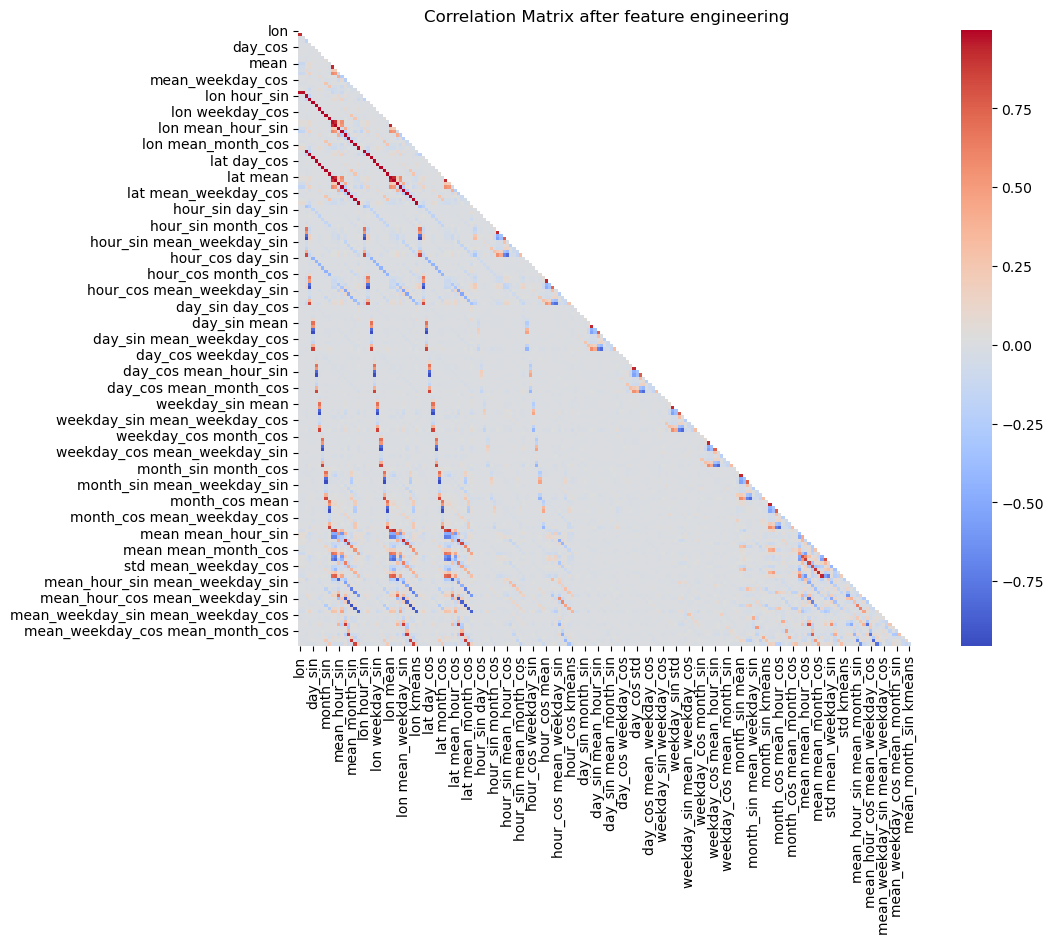

In [365]:
numeric_columns = train_prepared.select_dtypes(include=['float64', 'int64', 'int32']).columns

correlation_matrix = train_prepared[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)) ,
             annot=False, cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix after feature engineering')
plt.show()

In [20]:
train_prepared.shape

(3635541, 171)

In [21]:
train_mean['point'] = train_mean.index
train_mean.reset_index(drop=True, inplace=True)
train_mean.head()

,mean,std,mean_hour_sin,mean_hour_cos,mean_weekday_sin,mean_weekday_cos,mean_month_sin,mean_month_cos,kmeans,point
0,8.785714,5.999213,-0.047789,-0.099601,-0.004299,-0.006992,0.037874,0.059686,49,0101000020E61000000000000000000000000000000000...
1,1.000000,0.000000,0.262452,-0.745110,-0.037620,0.032977,0.085366,0.931379,34,0101000020E610000002A5EC7AB31D3E4097654065F8EA...
2,1.000000,0.000000,-0.399786,-0.381317,0.368936,0.044552,0.014886,0.632906,9,0101000020E610000002BF48199F3F3E400A41C338F1F6...
3,1.313953,0.662472,0.014848,-0.403646,0.032318,0.107681,-0.861397,-0.120062,6,0101000020E610000002BF48199F3F3E400A721DB144FC...
4,1.051724,0.223404,-0.104334,-0.403783,0.028807,0.073177,-0.145314,0.052796,38,0101000020E610000002BF48199F3F3E400B9A5B330603...


In [47]:
train_mean.columns

Index(['mean', 'std', 'mean_hour_sin', 'mean_hour_cos', 'mean_weekday_sin',
       'mean_weekday_cos', 'mean_month_sin', 'mean_month_cos', 'kmeans',
       'point'],
      dtype='object')

In [22]:
train_prepared['point'] = train_merged['point']

In [ ]:
train_prepared = train_prepared.merge(train_mean[['point', 'kmeans']], on='point', how='left')
train_prepared.drop(columns=['point'], inplace=True)

In [25]:
train_prepared.head()

,lon,lat,hour_sin,hour_cos,day_sin,day_cos,weekday_sin,weekday_cos,month_sin,month_cos,...,mean_hour_cos mean_month_sin,mean_hour_cos mean_month_cos,mean_weekday_sin mean_weekday_cos,mean_weekday_sin mean_month_sin,mean_weekday_sin mean_month_cos,mean_weekday_cos mean_month_sin,mean_weekday_cos mean_month_cos,mean_month_sin mean_month_cos,point,kmeans
0,0.000000,0.000000,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,-0.003772,-0.005945,0.000030,-0.000163,-0.000257,-0.000265,-0.000417,0.002261,0101000020E61000000000000000000000000000000000...,49
1,30.183394,59.849244,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,-0.050865,-0.005037,-0.000010,-0.001399,-0.000139,0.000216,0.000021,0.002899,0101000020E61000000000000000000000000000000000...,49
2,30.284454,59.919107,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,-0.006945,-0.057862,0.001965,-0.000808,-0.006729,-0.001180,-0.009830,0.004039,0101000020E61000000000000000000000000000000000...,49
3,30.315895,59.965226,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,0.020068,-0.035986,0.001936,0.006174,-0.011071,0.000914,-0.001640,-0.005228,0101000020E61000000000000000000000000000000000...,49
4,30.378777,60.033724,0.0,1.0,0.201299,0.97953,0.781831,0.62349,0.5,0.866025,...,-0.036610,-0.030139,-0.000084,0.001261,0.001038,-0.001193,-0.000982,0.014752,0101000020E61000000000000000000000000000000000...,49


# Training

## HistGradientBoostingRegressor

These histogram-based estimators can be orders of magnitude faster than GradientBoostingClassifier and GradientBoostingRegressor when the number of samples is larger than tens of thousands of samples.

They also have built-in support for missing values, which avoids the need for an imputer.

These fast estimators first bin the input samples X into integer-valued bins (typically 256 bins) which tremendously reduces the number of splitting points to consider, and allows the algorithm to leverage integer-based data structures (histograms) instead of relying on sorted continuous values when building the trees.

In [672]:
histgrad = HistGradientBoostingRegressor(
    max_iter = 5000,
    learning_rate = 0.001,
    categorical_features=None,
    early_stopping=True,
    monotonic_cst={'mean': 1, 'std': 1},
    random_state=23
)
histgrad.fit(train_prepared, train_merged['sum'])

HistGradientBoostingRegressor(categorical_features=None, early_stopping=True,
                              learning_rate=0.001, max_iter=5000,
                              monotonic_cst={'mean': 1, 'std': 1},
                              random_state=23)

In [688]:
from pickle import dump
with open("histgrad_new2.pkl", "wb") as f:
    dump(histgrad, f, protocol=5)

## KNeighbors

In [90]:
kneigh = KNeighborsRegressor(n_neighbors=100, leaf_size = 155, weights='distance', p=1, n_jobs=-1)
kneigh.fit(train_prepared, train_merged['sum'])

KNeighborsRegressor(leaf_size=155, n_jobs=-1, n_neighbors=100, p=1,
                    weights='distance')

## LightGBM

In [651]:
lgbm = lgb.LGBMRegressor(
    num_leaves = 255,
    min_child_samples=10,
    learning_rate = 0.001,
    n_estimators = 2000,
    random_state = 23
)

lgbm.fit(train_prepared, train_merged['sum'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38172
[LightGBM] [Info] Number of data points in the train set: 3635541, number of used features: 172
[LightGBM] [Info] Start training from score 2.345325


LGBMRegressor(learning_rate=0.001, min_child_samples=10, n_estimators=2000,
              num_leaves=255, random_state=23)

In [ ]:
# from pickle import dump
# with open("lgbm_new.pkl", "wb") as f:
#     dump(lgbm, f, protocol=5)

## CatBoost

In [248]:
cat = CatBoostRegressor(
    n_estimators = 2000,
    max_leaves = 255,
    min_child_samples = 10,
    grow_policy='Lossguide',
    learning_rate = 0.001,
    random_state=23,
    logging_level='Silent'
    )

cat.fit(train_prepared, train_merged['sum'])

In [ ]:
# from pickle import dump
# with open("cat_new2.pkl", "wb") as f:
#     dump(cat, f, protocol=5)

In [ ]:
# cat.save_model('cat_new2.cbm',
#            format="cbm",
#            export_parameters=None,
#            pool=None)


## Multi-layer Perceptron

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes = 30, learning_rate_init=0.001,
                    random_state=23, max_iter=3000, epsilon=1e-9)

mlp.fit(train_prepared, train_merged['sum'])

MLPRegressor(epsilon=1e-09, hidden_layer_sizes=30, max_iter=3000,
             random_state=23)

In [ ]:
# from pickle import dump
# with open("mlp_new2.pkl", "wb") as f:
#     dump(mlp, f, protocol=5)

# Validation

In [689]:
def prepare(df, feature, point_means, poly):
    if df[feature].dtype != 'M8[ns]':
        df[feature] = pd.to_datetime(df[feature], unit='s')
    
    df['hour'] = df[feature].dt.hour 
    df['day'] = df[feature].dt.day
    df['day_of_week'] = df[feature].dt.weekday  
    df['month'] = df[feature].dt.month 

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    df['weekday_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df = df.drop(columns=['hour', 'day', 'day_of_week', 'month'])

    df = df.merge(point_means, on='point', how='left')

    kmeans_col = df['kmeans']

    df = pd.DataFrame(poly.transform(df[poly.feature_names_in_]), columns = poly.get_feature_names_out())

    df['kmeans'] = kmeans_col #df.merge(point_means[['point', 'kmeans']], on='point', how='left')
        
    return df

### Error function

In [ ]:
# error function
def error_calc(y_true: np.array, y_pred: np.array) -> float:
    error = abs(y_pred - y_true) / y_pred
    return np.mean(error)

In [691]:
val = pd.read_csv('test.csv')
val.rename(columns={'hour': 'timestamp'}, inplace=True)
val['timestamp'] = pd.to_datetime(val['timestamp'], unit='s')
val.head()

,timestamp,lat,lon,point,sum,error
0,2020-02-26 10:00:00,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,2020-02-17 11:00:00,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,2020-02-12 16:00:00,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,2020-02-12 13:00:00,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,2020-02-15 13:00:00,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069


### Make prediction df

In [692]:
predict_df = val.copy()
predict_df = predict_df.groupby(['point']).agg({
    'lat': 'first',
    'lon': 'first',}).reset_index()

In [694]:
start_time = "2020-02-01 00:00:00"
end_time = "2020-02-29 22:00:00"
time_range = pd.date_range(start=start_time, end=end_time, freq="1H")

expanded_data = []
for _, row in predict_df.iterrows():
    for timestamp in time_range:
        expanded_data.append({
            "point": row["point"],
            "lat": row["lat"],
            "lon": row["lon"],
            "timestamp": timestamp
        })

predict_df = pd.DataFrame(expanded_data)
predict_df['timestamp'] = pd.to_datetime(predict_df['timestamp'], unit='s')
predict_df.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/3736304852.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start_time, end=end_time, freq="1H")


,point,lat,lon,timestamp
0,0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...,59.941612,30.37204,2020-02-01 00:00:00
1,0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...,59.941612,30.37204,2020-02-01 01:00:00
2,0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...,59.941612,30.37204,2020-02-01 02:00:00
3,0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...,59.941612,30.37204,2020-02-01 03:00:00
4,0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...,59.941612,30.37204,2020-02-01 04:00:00


In [ ]:
predict_processed = prepare(predict_df, 'timestamp', train_mean, poly)

models = {
    'histgrad_pred': histgrad,
    'lgbm_pred': lgbm,
    'catboost_pred': cat,
    'mlp_pred': mrp,
    'kneigh_pred': kneigh
}

for col, model in tqdm(models.items(), desc="Processing models"):
    predict_df[col] = np.ceil(model.predict(predict_processed))

Processing models: 100%|██████████| 5/5 [1:36:10<00:00, 1154.07s/it]


In [ ]:
# predict_df['catboost_pred'] = np.ceil(cat.predict(predict_processed))
# predict_df['histgrad_pred'] = np.ceil(histgrad.predict(predict_processed))
# predict_df['lgbm_pred'] = np.ceil(lgbm.predict(predict_processed))
# predict_df['mlp_pred'] = np.ceil(mrp.predict(predict_processed))
# predict_df['kneigh_pred'] = np.ceil(kneigh.predict(predict_processed))

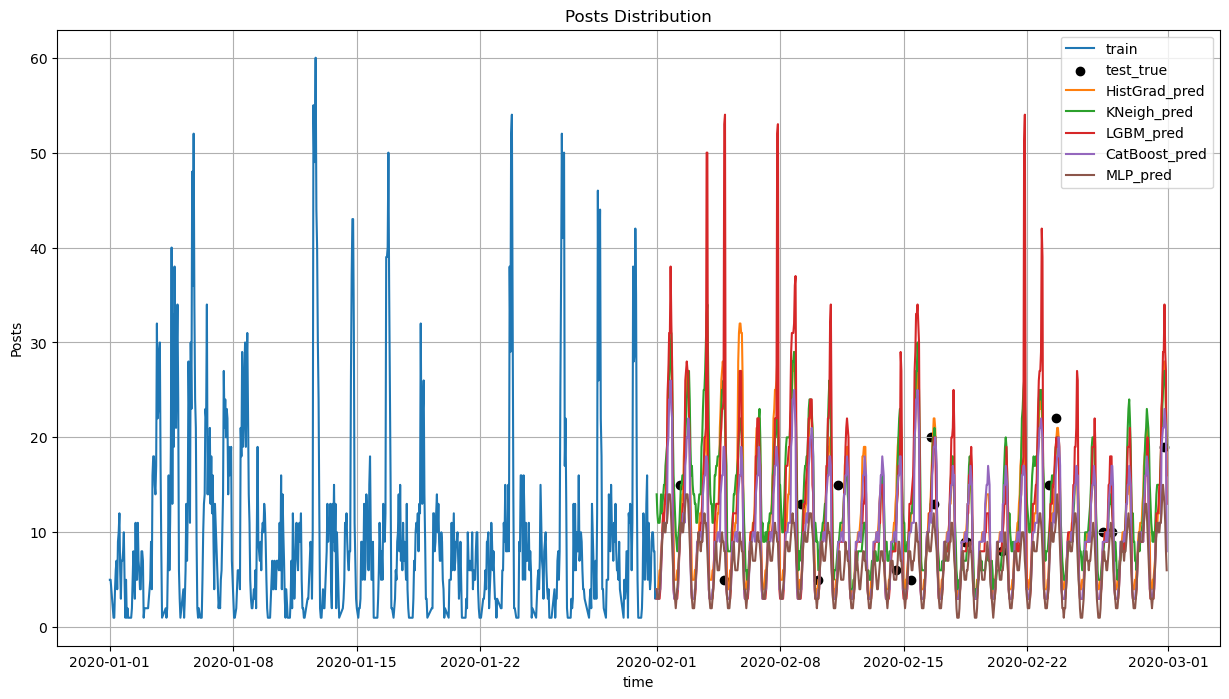

In [711]:
random_point = np.random.choice(val['point'].unique(), size = 1)[0] # val['point'].sample(1).values[0])
filtered_train = train_merged[(train_merged['timestamp'] >= '2020-01-01') & (train_merged['point'] == random_point)].sort_values(
    by=['timestamp'], ascending=True)
predict_df = predict_df.sort_values(by=['timestamp'], ascending=True)
val = val.sort_values(by=['timestamp'], ascending=True)

plt.figure(figsize=(15,8))

plt.plot(filtered_train['timestamp'], filtered_train['sum'], label = 'train')

plt.scatter(val['timestamp'][val['point'] == random_point],
      val['sum'][val['point'] == random_point], label = 'test_true', color='black')

plt.plot(predict_df['timestamp'][predict_df['point'] == random_point],
      predict_df['histgrad_pred'][predict_df['point'] == random_point], label = 'HistGrad_pred',)

plt.plot(predict_df['timestamp'][predict_df['point'] == random_point]
         , predict_df['kneigh_pred'][predict_df['point'] == random_point], label = 'KNeigh_pred')

plt.plot(predict_df['timestamp'][predict_df['point'] == random_point]
         , predict_df['lgbm_pred'][predict_df['point'] == random_point], label = 'LGBM_pred')

plt.plot(predict_df['timestamp'][predict_df['point'] == random_point]
         , predict_df['catboost_pred'][predict_df['point'] == random_point], label = 'CatBoost_pred')

plt.plot(predict_df['timestamp'][predict_df['point'] == random_point]
         , predict_df['mlp_pred'][predict_df['point'] == random_point], label = 'MLP_pred')


plt.ylabel('Posts')
plt.xlabel('time')
plt.title('Posts Distribution')
plt.legend(loc='best')
plt.grid()

In [ ]:
# predict_df.to_csv('predict_df.csv')

In [697]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [698]:
models_df = pd.DataFrame(
    data={
        'Model': ['HistGradientBoosting', 'KNeighbors', 'LGBM', 'CatBoost', 'MLP'],
        'Custom_Metric': [0, 0, 0, 0, 0],
        'MSE': [0, 0, 0, 0, 0],
        'RMSE': [0, 0, 0, 0, 0],
        'MAPE': [0, 0, 0, 0, 0],
        'SMAPE': [0, 0, 0, 0, 0]
    }
)

models_df.head()

,Model,Custom_Metric,MSE,RMSE,MAPE,SMAPE
0,HistGradientBoosting,0,0,0,0,0
1,KNeighbors,0,0,0,0,0
2,LGBM,0,0,0,0,0
3,CatBoost,0,0,0,0,0
4,MLP,0,0,0,0,0


In [699]:
val = val.merge(predict_df[['point', 'timestamp', 'histgrad_pred', 'kneigh_pred', 'lgbm_pred', 'catboost_pred', 'mlp_pred']],
 on=['point', 'timestamp'], how='inner')
val.head()

,timestamp,lat,lon,point,sum,error,histgrad_pred,kneigh_pred,lgbm_pred,catboost_pred,mlp_pred
0,2020-02-01 06:00:00,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,7,1.088069,3.0,3.0,3.0,3.0,3.0
1,2020-02-01 06:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,8,2.754735,4.0,4.0,4.0,4.0,3.0
2,2020-02-01 08:00:00,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,13,0.379735,8.0,7.0,8.0,8.0,7.0
3,2020-02-01 10:00:00,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,0.254735,11.0,9.0,9.0,11.0,11.0
4,2020-02-01 10:00:00,60.039332,30.322632,0101000020E61000009E01B90998523E40888919D70805...,7,5.754735,4.0,4.0,4.0,5.0,5.0


In [700]:
model_mapping = {
    'HistGradientBoosting': 'histgrad_pred',
    'KNeighbors': 'kneigh_pred',
    'LGBM': 'lgbm_pred',
    'CatBoost': 'catboost_pred',
    'MLP': 'mlp_pred',
}

metric_mapping = {
    'Custom_Metric': error_calc,
    'MSE': mean_squared_error,
    'RMSE':root_mean_squared_error,
    'MAPE': mean_absolute_percentage_error,
    'SMAPE': symmetric_mean_absolute_percentage_error
}

for model in models_df['Model'].values:
    pred_column = model_mapping.get(model)
    for metric in models_df.columns[1:]:
        try:
            metric_func = metric_mapping.get(metric)
            models_df.loc[models_df['Model'] == model, metric] = round(metric_func(val['sum'], val[pred_column]), 2)
        except Exception as e:
            print(f"Error for model: {model}, metric: {metric}, error: {e}")

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/3689974126.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_df.loc[models_df['Model'] == model, metric] = round(metric_func(val['sum'], val[pred_column]), 2)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/3689974126.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_df.loc[models_df['Model'] == model, metric] = round(metric_func(val['sum'], val[pred_column]), 2)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/3689974126.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error i

In [701]:
models_df

,Model,Custom_Metric,MSE,RMSE,MAPE,SMAPE
0,HistGradientBoosting,0.95,50.01,7.07,0.40,0.53
1,KNeighbors,1.00,48.55,6.97,0.42,0.56
2,LGBM,1.07,58.57,7.65,0.43,0.57
3,CatBoost,0.96,50.23,7.09,0.40,0.54
4,MLP,0.95,48.36,6.95,0.39,0.52


In [ ]:
# models_df.to_csv('models_df.csv')

# Feature Importance models

In [491]:
# lgb.plot_importance(lgbm, importance_type='gain',
# max_num_features = 10,
# figsize=(10,8),
# grid = False,
# precision = 0,
# title="LightGBM Feature Importance (Gain)")

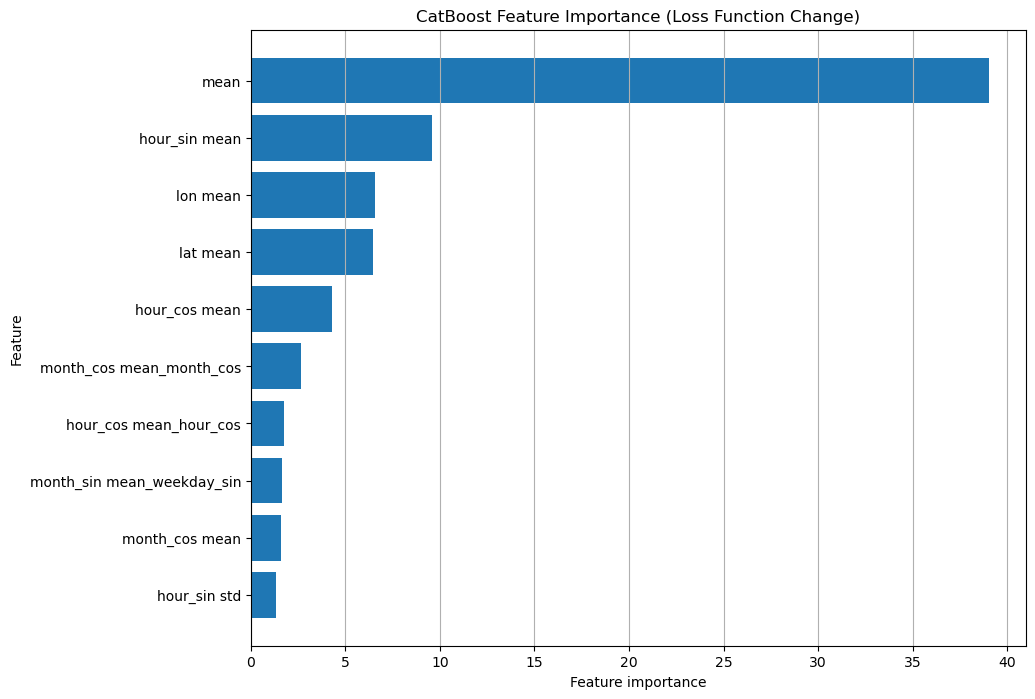

In [673]:
cat_features = cat.get_feature_importance(prettified=True).sort_values(by='Importances', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(y=np.arange(10), width=cat_features['Importances'][-10:], tick_label = cat_features['Feature Id'][-10:], )
plt.title('CatBoost Feature Importance (Loss Function Change)')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.grid(axis='x')

In [ ]:
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(train_prepared, 100)

In [ ]:
explainer_nn = shap.KernelExplainer(mrp.predict, X_train_summary, nsamples=375)

In [674]:
X_test = predict_processed.sample(n=1000, random_state=23).reset_index(drop=True)

In [675]:
shap_values_nn = explainer_nn(X_test)

100%|██████████| 1000/1000 [16:46<00:00,  1.01s/it]


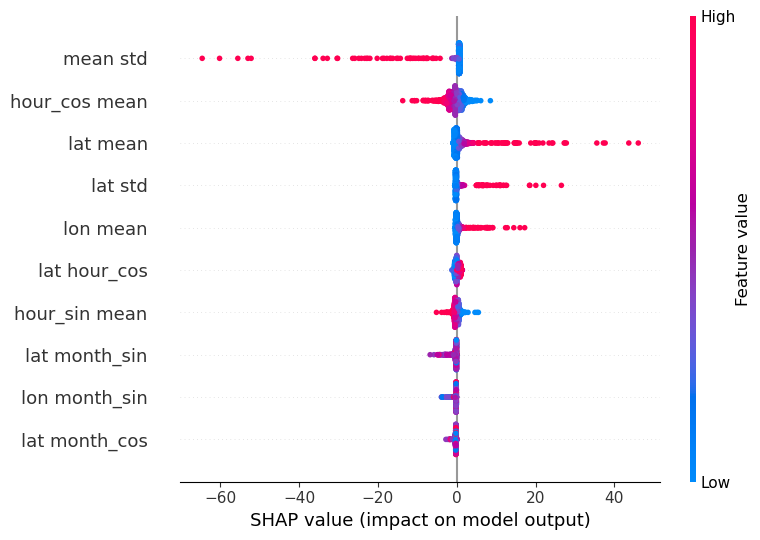

In [676]:
shap.summary_plot(shap_values_nn, max_display=10)

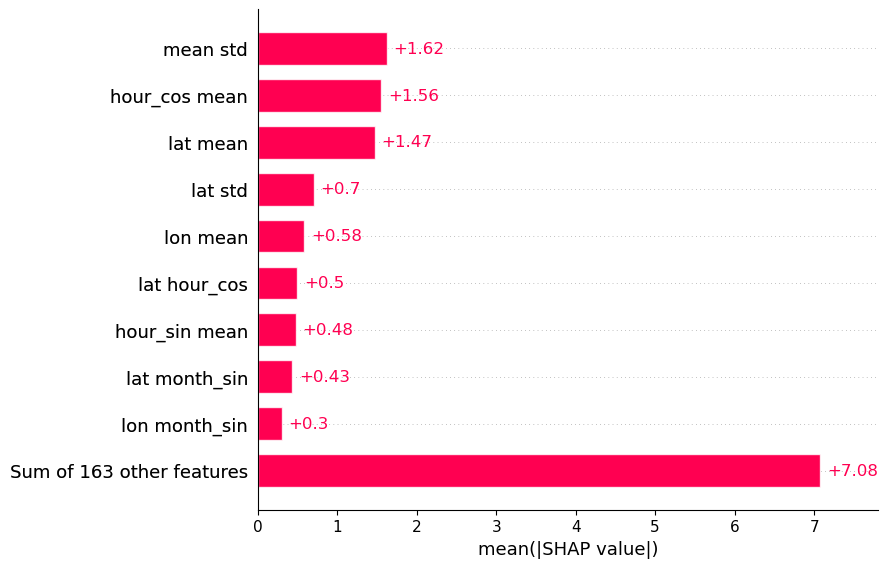

In [677]:
shap.plots.bar(shap_values_nn, max_display=10)

# Base models (without feature engineering)

In [452]:
train_base = train_grouped.merge(uniq_geo, on='point', how='left')
train_base.columns
train_base = train_base.drop(columns=['point', 'timestamp'])

In [453]:
hist_base = HistGradientBoostingRegressor(random_state=23)
hist_base.fit(train_base.drop(columns=['sum']), train_base['sum'])

HistGradientBoostingRegressor(random_state=23)

In [456]:
k_base = KNeighborsRegressor(n_jobs=-1)
k_base.fit(train_base.drop(columns=['sum']), train_base['sum'])

KNeighborsRegressor(n_jobs=-1)

In [457]:
lgbm_base = lgb.LGBMRegressor(random_state = 23)

lgbm_base.fit(train_base.drop(columns=['sum']), train_base['sum'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 3635541, number of used features: 6
[LightGBM] [Info] Start training from score 2.345325


LGBMRegressor(random_state=23)

In [458]:
cat_base = CatBoostRegressor(random_state=23,logging_level='Silent')

cat_base.fit(train_base.drop(columns=['sum']), train_base['sum'])

In [459]:
mlp_base = MLPRegressor(random_state=23)

mlp_base.fit(train_base.drop(columns=['sum']), train_base['sum'])

MLPRegressor(random_state=23)

In [464]:
train_base.columns

Index(['month', 'day', 'hour', 'day_of_week', 'sum', 'lon', 'lat'], dtype='object')

In [713]:
pred_base = predict_df.copy()
pred_base = pred_base.drop(columns=['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'histgrad_pred', 'lgbm_pred',
       'catboost_pred', 'mlp_pred', 'kneigh_pred'])

In [469]:
pred_base.columns

Index(['point', 'lat', 'lon', 'timestamp', 'hour', 'day', 'day_of_week',
       'month', 'catboost_pred', 'histgrad_pred', 'lgbm_pred', 'mlp_pred',
       'kneigh_pred'],
      dtype='object')

In [714]:
pred_base['cat_base'] = np.ceil(cat_base.predict(pred_base[['month', 'day', 'hour', 'day_of_week', 'lon', 'lat']]))
pred_base['hist_base'] = np.ceil(hist_base.predict(pred_base[['month', 'day', 'hour', 'day_of_week', 'lon', 'lat']]))
pred_base['lgbm_base'] = np.ceil(lgbm_base.predict(pred_base[['month', 'day', 'hour', 'day_of_week', 'lon', 'lat']]))
pred_base['mlp_base'] = np.ceil(mlp_base.predict(pred_base[['month', 'day', 'hour', 'day_of_week', 'lon', 'lat']]))
pred_base['k_base'] = np.ceil(k_base.predict(pred_base[['month', 'day', 'hour', 'day_of_week', 'lon', 'lat']]))

In [715]:
val_base = val.copy()
val_base.drop(columns=['histgrad_pred','kneigh_pred', 'lgbm_pred', 'catboost_pred', 'mlp_pred'], inplace = True)
val_base = val_base.merge(pred_base[['point', 'timestamp', 'hist_base', 'k_base', 'lgbm_base', 'cat_base', 'mlp_base']],
 on=['point', 'timestamp'], how='inner')
val_base.head()

,timestamp,lat,lon,point,sum,error,hist_base,k_base,lgbm_base,cat_base,mlp_base
0,2020-02-01 06:00:00,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,7,1.088069,3.0,2.0,3.0,3.0,2.0
1,2020-02-01 06:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,8,2.754735,4.0,2.0,4.0,4.0,2.0
2,2020-02-01 08:00:00,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,13,0.379735,6.0,5.0,5.0,9.0,2.0
3,2020-02-01 10:00:00,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,0.254735,11.0,4.0,8.0,10.0,3.0
4,2020-02-01 10:00:00,60.039332,30.322632,0101000020E61000009E01B90998523E40888919D70805...,7,5.754735,3.0,1.0,2.0,3.0,3.0


In [716]:
models_base = pd.DataFrame(
    data={
        'Model_base': ['HistGradientBoosting', 'KNeighbors', 'LGBM', 'CatBoost', 'MLP'],
        'Custom_Metric': [0, 0, 0, 0, 0],
        'MSE': [0, 0, 0, 0, 0],
        'RMSE': [0, 0, 0, 0, 0],
        'MAPE': [0, 0, 0, 0, 0],
        'SMAPE': [0, 0, 0, 0, 0]
    }
)

models_base.head()

,Model_base,Custom_Metric,MSE,RMSE,MAPE,SMAPE
0,HistGradientBoosting,0,0,0,0,0
1,KNeighbors,0,0,0,0,0
2,LGBM,0,0,0,0,0
3,CatBoost,0,0,0,0,0
4,MLP,0,0,0,0,0


In [717]:
model_mapping_base = {
    'HistGradientBoosting': 'hist_base',
    'KNeighbors': 'k_base',
    'LGBM': 'lgbm_base',
    'CatBoost': 'cat_base',
    'MLP': 'mlp_base',
}

metric_mapping_base = {
    'Custom_Metric': error_calc,
    'MSE': mean_squared_error,
    'RMSE':root_mean_squared_error,
    'MAPE': mean_absolute_percentage_error,
    'SMAPE': symmetric_mean_absolute_percentage_error
}

for model in models_base['Model_base'].values:
    pred_column = model_mapping_base.get(model)
    for metric in models_base.columns[1:]:
        try:
            metric_func = metric_mapping_base.get(metric)
            models_base.loc[models_base['Model_base'] == model, metric] = round(metric_func(val_base['sum'], val_base[pred_column]), 2)
        except Exception as e:
            print(f"Error for model: {model}, metric: {metric}, error: {e}")

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/2247887205.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.59' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_base.loc[models_base['Model_base'] == model, metric] = round(metric_func(val_base['sum'], val_base[pred_column]), 2)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/2247887205.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '62.57' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_base.loc[models_base['Model_base'] == model, metric] = round(metric_func(val_base['sum'], val_base[pred_column]), 2)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_87353/2247887205.py:22: FutureWarning: Setting an item of incompatible dtype i

In [718]:
models_base

,Model_base,Custom_Metric,MSE,RMSE,MAPE,SMAPE
0,HistGradientBoosting,1.59,62.57,7.91,0.53,0.75
1,KNeighbors,2.16,78.77,8.88,0.60,0.87
2,LGBM,1.61,63.36,7.96,0.53,0.75
3,CatBoost,-inf,52.39,7.24,0.45,0.62
4,MLP,3.28,95.14,9.75,0.68,1.08


In [ ]:
# models_base.to_csv('models_base.csv')

# Improved error function

In [728]:
# error function
def fixed_error_calc(y_true: np.array, y_pred: np.array) -> float:
    error = abs(y_pred - y_true) / y_true
    return np.mean(error)

In [729]:
for model in models_df['Model'].values:
    m = model_mapping.get(model)

    print(f'Improved func error for {model} value is: {round(fixed_error_calc(val["sum"], val[m]), 2)}')


Improved func error for HistGradientBoosting value is: 0.4
Improved func error for KNeighbors value is: 0.42
Improved func error for LGBM value is: 0.43
Improved func error for CatBoost value is: 0.4
Improved func error for MLP value is: 0.39
